In [1]:
# See https://github.com/tensorflow/tensorflow/issues/31249
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers

tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
# tf.compat.v1.disable_eager_execution()

In [2]:
batch_size=512
x2_dist=tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(batch_size)
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(batch_size, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

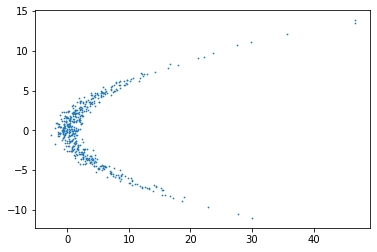

In [3]:
plt.scatter(x_samples[:,0], x_samples[:,1], s=.5)

In [4]:
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=.5, validate_args=True, name="leaky_relu"):
        super().__init__(inverse_min_event_ndims=1, validate_args=validate_args, name=name)
        self.alpha = alpha
    
    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)
    
    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1./ self.alpha*y)
    
    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1/self.alpha * I)
        log_abs_det_j_inv = tf.math.log(tf.math.abs(J_inv))
        return tf.reduce_sum(log_abs_det_j_inv, axis=1)

In [5]:
def get_dist(var_list, num_layers):
    base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
    bijectors = []
    for i in range(num_layers):
        V = var_list[4*i]
        shift = var_list[4*i+1]
        L = var_list[4*i+2]
        alpha = var_list[4*i+3] + .1
        bijectors.append(tfb.Affine(
            scale_tril=tfd.fill_triangular(L),
            scale_perturb_factor=V,
            shift=shift,))
        bijectors.append(LeakyReLU(alpha=alpha))
    mlp_bijector = tfb.Chain(list(reversed(bijectors[:-1])), name='2d_mlp_bijector')
    dist = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=mlp_bijector
    )
    return dist

In [6]:
class NormalizingFlow(layers.Layer):

    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        self.var_list = []
        d, r = 2, 2
        DTYPE = tf.float32
        self.num_layers = 6
        for i in range(self.num_layers):
            V = self.add_weight(name='V', shape=[d,r], initializer=tf.compat.v1.glorot_uniform_initializer())
            shift = self.add_weight(name='shift', shape=[d], initializer=tf.compat.v1.glorot_uniform_initializer())
            L = self.add_weight(name='L', shape=[int(d * (d+1)/2)], initializer=tf.compat.v1.glorot_uniform_initializer())
            alpha = self.add_weight(name='alpha', shape=[], initializer=tf.compat.v1.glorot_uniform_initializer())
            self.var_list.extend([V, shift, L, alpha])

    def call(self, inputs):
        dist = get_dist(self.var_list, self.num_layers)
        return dist.log_prob(inputs)

In [184]:
normalizing_flow_layer = NormalizingFlow()

In [185]:
-tf.reduce_mean(normalizing_flow_layer(x_samples))

<tf.Tensor: id=266376, shape=(), dtype=float32, numpy=3667.6108>

In [8]:
inputs = keras.Input(shape=x_samples.shape[-1], name='x_samples')
outputs = NormalizingFlow()(inputs)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [10]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored from {}".format(manager.latest_checkpoint))
else:
  print("Initializing from scratch.")

Restored from ./tf_ckpts/ckpt-5


In [189]:
@tf.function
def train_step(x_samples):
    with tf.GradientTape() as tape:
        z_samples = model(x_samples)
        loss = -tf.reduce_mean(z_samples)
    print("loss: ", loss)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
#     gradients = tape.gradient(loss, var_list)
#     print("gradients: ", gradients[:-1])
#     optimizer.apply_gradients(zip(gradients[:-1], var_list[:-1]))

In [190]:
save_path = manager.save()

In [191]:
NUM_STEPS = 4_000
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    ckpt.step.assign_add(1)
    if int(ckpt.step) % 1000 == 0:
        save_path = manager.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
    if i%200 == 0:
        print(i)
    train_step(x_samples)

0
loss:  Tensor("Neg:0", shape=(), dtype=float32)


W0809 00:04:40.414765 140312706836288 optimizer_v2.py:979] Gradients does not exist for variables ['normalizing_flow_32/alpha:0'] when minimizing the loss.


loss:  Tensor("Neg:0", shape=(), dtype=float32)


W0809 00:04:43.581470 140312706836288 optimizer_v2.py:979] Gradients does not exist for variables ['normalizing_flow_32/alpha:0'] when minimizing the loss.


200
400
600
800
Saved checkpoint for step 1000: ./tf_ckpts/ckpt-2
1000
1200
1400
1600
1800
Saved checkpoint for step 2000: ./tf_ckpts/ckpt-3
2000
2200
2400
2600
2800
Saved checkpoint for step 3000: ./tf_ckpts/ckpt-4
3000
3200
3400
3600
3800
Saved checkpoint for step 4000: ./tf_ckpts/ckpt-5


In [ ]:
for example in toy_dataset():
  loss = train_step(net, example, opt)
  ckpt.step.assign_add(1)
  if int(ckpt.step) % 10 == 0:
    save_path = manager.save()
    print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
    print("loss {:1.2f}".format(loss.numpy()))